In [2]:

from numpy.random import seed
seed(1)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import itertools

import keras
from keras.applications import ResNet50, Xception
from keras.models import Sequential, Model
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from keras import backend as K
#from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras import regularizers
from keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
import pickle
from datetime import datetime

np.random.seed(123)
from config import config
from utils.load_data import load_skin_data
import tensorflow as tf


In [2]:


lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
    
df = load_skin_data(
        dataset_dir=config.DATASET_DIR,
        metadata_path=config.METADATA_PATH,
        lesion_type_dict=lesion_type_dict
    )
    
    
    # Display the shape of the dataframe
print(f"Dataframe shape: {df.shape}")
    


Dataframe shape: (10015, 10)


In [3]:
def basic_EDA(df):
    size = df.shape
    sum_duplicates = df.duplicated().sum()
    sum_null = df.isnull().sum().sum()
    is_NaN = df. isnull()
    row_has_NaN = is_NaN. any(axis=1)
    rows_with_NaN = df[row_has_NaN]
    count_NaN_rows = rows_with_NaN.shape
    return print("Number of Samples: %d,\nNumber of Features: %d,\nDuplicated Entries: %d,\nNull Entries: %d,\nNumber of Rows with Null Entries: %d %.1f%%" %(size[0],size[1], sum_duplicates, sum_null,count_NaN_rows[0],(count_NaN_rows[0] / df.shape[0])*100))

In [4]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./data/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./data/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./data/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./data/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./data/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [5]:
df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'path', 'cell_type', 'cell_type_idx'],
      dtype='object')

In [ ]:
from valisataiontest_3 import StratifiedCrossValidator

In [7]:
# Initialisation avec les nouveaux paramètres
validator = StratifiedCrossValidator(
    n_splits=5,
    test_size=0.2,  # 20% pour test
    val_size=0.1    # 20% pour validation (sur les 80% restants)
)


# Préparation des données
data = validator.prepare_data(df, target_col='dx')

splits = validator.create_stratified_splits_finale(data, 'dx')



 Distribution des classes:
   nv: 6705 échantillons (66.9%)
   mel: 1113 échantillons (11.1%)
   bkl: 1099 échantillons (11.0%)
   bcc: 514 échantillons (5.1%)
   akiec: 327 échantillons (3.3%)
   vasc: 142 échantillons (1.4%)
   df: 115 échantillons (1.1%)
[INFO] Sauvegarde des splits dans la racine


In [8]:
train_data, test_data, val_data = validator.get_fold_data(df, fold=0)

In [9]:
train_data

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
1294,HAM_0001203,ISIC_0030134,mel,histo,30.0,female,abdomen,./data/HAM10000_images_part_2/ISIC_0030134.jpg,Melanoma,5
9927,HAM_0006301,ISIC_0031823,akiec,histo,75.0,male,neck,./data/HAM10000_images_part_2/ISIC_0031823.jpg,Actinic keratoses,0
1109,HAM_0005518,ISIC_0032410,df,histo,30.0,male,lower extremity,./data/HAM10000_images_part_2/ISIC_0032410.jpg,Dermatofibroma,3
1901,HAM_0000709,ISIC_0033114,mel,histo,45.0,female,lower extremity,./data/HAM10000_images_part_2/ISIC_0033114.jpg,Melanoma,5
9529,HAM_0004350,ISIC_0033970,nv,consensus,40.0,female,unknown,./data/HAM10000_images_part_2/ISIC_0033970.jpg,Melanocytic nevi,4
...,...,...,...,...,...,...,...,...,...,...
386,HAM_0004491,ISIC_0028846,bkl,histo,45.0,male,face,./data/HAM10000_images_part_1/ISIC_0028846.jpg,Benign keratosis-like lesions,2
7333,HAM_0002574,ISIC_0032666,nv,histo,55.0,male,chest,./data/HAM10000_images_part_2/ISIC_0032666.jpg,Melanocytic nevi,4
1357,HAM_0007620,ISIC_0030089,mel,histo,55.0,female,back,./data/HAM10000_images_part_2/ISIC_0030089.jpg,Melanoma,5
9164,HAM_0005057,ISIC_0027711,nv,histo,40.0,male,back,./data/HAM10000_images_part_1/ISIC_0027711.jpg,Melanocytic nevi,4


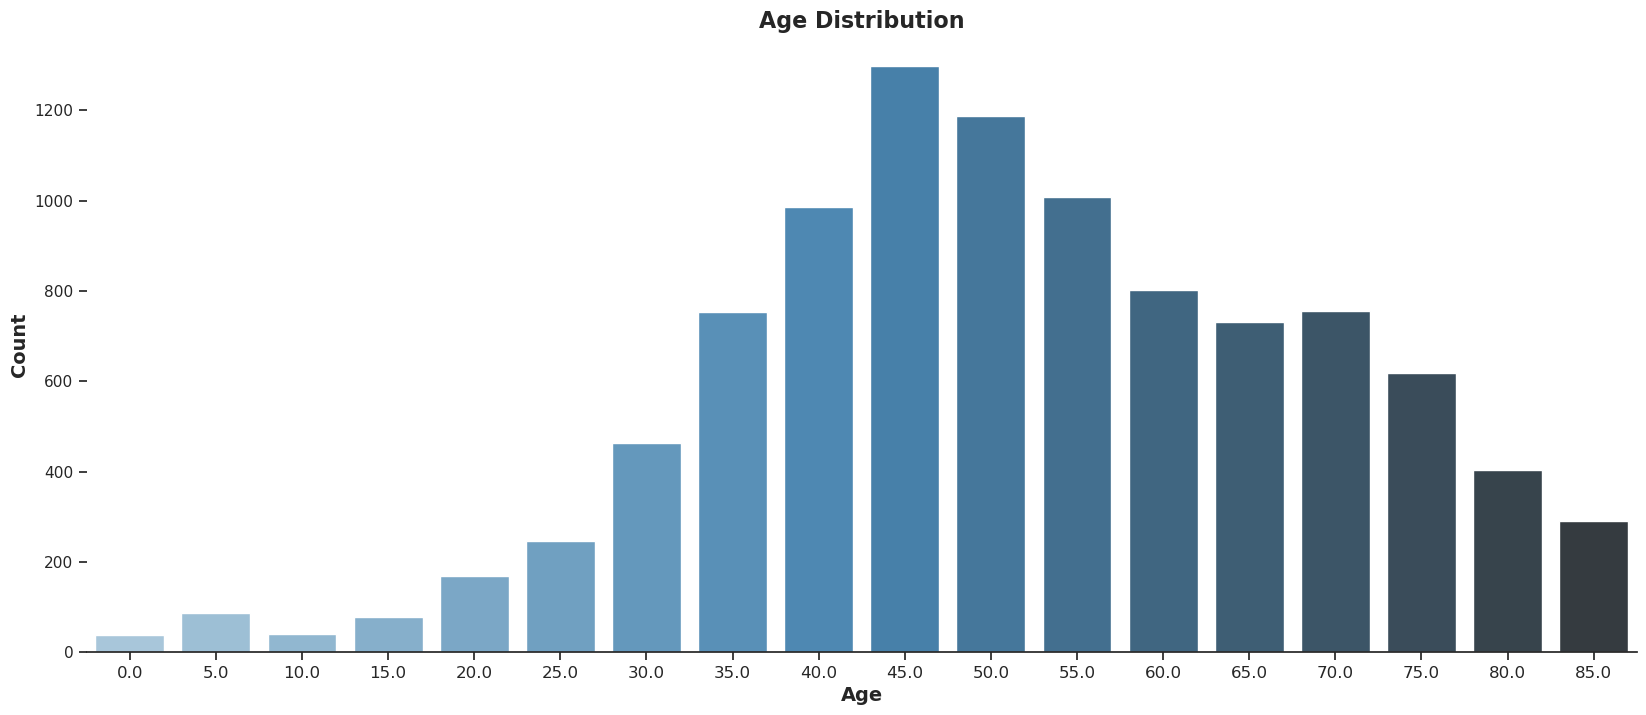

In [10]:
df['age'].fillna((df['age'].mode()), inplace=True)

plt.figure(figsize=(20,8))
sns.set(style="ticks", font_scale = 1)
ax = sns.countplot(data = df,x='age',palette="Blues_d")
sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Age',fontsize = 14,weight = 'bold')
ax.set_ylabel('Count',fontsize = 14,weight = 'bold')
plt.title('Age Distribution', fontsize = 16,weight = 'bold')
plt.show()

In [11]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler



In [12]:
label_encoder = LabelEncoder()
y= label_encoder.fit_transform(df['dx'])
onehot_sexe = OneHotEncoder()
sex_t = onehot_sexe.fit_transform(df[['sex']])

In [13]:
standard_scaler = StandardScaler()

age_t = standard_scaler.fit_transform(df[['age']])

In [14]:
df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'path', 'cell_type', 'cell_type_idx'],
      dtype='object')

In [15]:
df.sex.unique()

array(['male', 'female', 'unknown'], dtype=object)

In [16]:
def handle_missing_values(df):
    df = df.copy()

    if 'age' in df.columns:
        median_age = df['age'].median()
        df['age'].fillna(median_age, inplace=True)

    if 'sex' in df.columns:
        df['sex'] = df['sex'].replace(['unknown', 'Unknown'], np.nan)

        # Remplir les valeurs manquantes avec le mode
        if df['sex'].isnull().any():
            mode_sex = df['sex'].mode()[0]
            df['sex'].fillna(mode_sex, inplace=True)

    return df


In [17]:
def prepare_features(X_train, X_test, X_val, target_col: str, transform_columns: list, save_dir: str = "encoders", fold_number: int = 0):

    os.makedirs(f'{save_dir}/fold_{fold_number}', exist_ok=True)

    # Encodage de la cible
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(X_train[target_col])
    y_val = label_encoder.transform(X_val[target_col])
    y_test = label_encoder.transform(X_test[target_col])

    # Gestion des valeurs manquantes
    X_train = handle_missing_values(X_train)
    X_val = handle_missing_values(X_val)
    X_test = handle_missing_values(X_test)

    # One-hot encoding
    onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    col_train = onehot_encoder.fit_transform(X_train[transform_columns])
    col_val = onehot_encoder.transform(X_val[transform_columns])
    col_test = onehot_encoder.transform(X_test[transform_columns])

    # Standardisation de l'âge
    scaler_age = StandardScaler()
    age_train = scaler_age.fit_transform(X_train[['age']])
    age_val = scaler_age.transform(X_val[['age']])
    age_test = scaler_age.transform(X_test[['age']])

    print("Shape col_train:", col_train.shape)
    print("Shape age_train:", age_train.shape)

    # Combinaison des features
    X_train_tab = np.concatenate([col_train, age_train], axis=1)
    X_val_tab = np.concatenate([col_val, age_val], axis=1)
    X_test_tab = np.concatenate([col_test, age_test], axis=1)

    # Sauvegarde
    joblib.dump(label_encoder, os.path.join(f'{save_dir}/fold_{fold_number}/', f"{fold_number}_label_encoder.pkl"))
    joblib.dump(onehot_encoder, os.path.join(f'{save_dir}/fold_{fold_number}/', f"{fold_number}_onehot_encoder.pkl"))
    joblib.dump(scaler_age, os.path.join(f'{save_dir}/fold_{fold_number}/', f"{fold_number}_scaler_age.pkl"))
    
    X_train.to_csv(os.path.join(f'{save_dir}/fold_{fold_number}/', f"X_train.csv"), index=False)
    X_val.to_csv(os.path.join(f'{save_dir}/fold_{fold_number}/', f"X_val.csv"), index=False)
    X_test.to_csv(os.path.join(f'{save_dir}/fold_{fold_number}/', f"X_test.csv"), index=False),

    # Retour
    X_dict = {"train": X_train_tab, "val": X_val_tab, "test": X_test_tab}
    y_dict = {"train": y_train, "val": y_val, "test": y_test}
    transformers = {
        "label_encoder": label_encoder,
        "onehot_encoder": onehot_encoder,
        "scaler_age": scaler_age
    }

    return X_dict, y_dict, transformers


In [18]:
column_names =  [ 'sex', 'localization']
X_dict, y_dict, transformers =  prepare_features(train_data, test_data, val_data,'dx', column_names, "encoders", fold_number=1)

Shape col_train: (7210, 17)
Shape age_train: (7210, 1)


In [19]:
transformers["onehot_encoder"].get_feature_names_out(column_names)

array(['sex_female', 'sex_male', 'localization_abdomen',
       'localization_acral', 'localization_back', 'localization_chest',
       'localization_ear', 'localization_face', 'localization_foot',
       'localization_genital', 'localization_hand',
       'localization_lower extremity', 'localization_neck',
       'localization_scalp', 'localization_trunk', 'localization_unknown',
       'localization_upper extremity'], dtype=object)

In [20]:
X_dict["train"].shape

(7210, 18)

In [21]:
train_data, test_data, val_data = validator.get_fold_data(df, fold=0)

In [22]:
train_data

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
1294,HAM_0001203,ISIC_0030134,mel,histo,30.0,female,abdomen,./data/HAM10000_images_part_2/ISIC_0030134.jpg,Melanoma,5
9927,HAM_0006301,ISIC_0031823,akiec,histo,75.0,male,neck,./data/HAM10000_images_part_2/ISIC_0031823.jpg,Actinic keratoses,0
1109,HAM_0005518,ISIC_0032410,df,histo,30.0,male,lower extremity,./data/HAM10000_images_part_2/ISIC_0032410.jpg,Dermatofibroma,3
1901,HAM_0000709,ISIC_0033114,mel,histo,45.0,female,lower extremity,./data/HAM10000_images_part_2/ISIC_0033114.jpg,Melanoma,5
9529,HAM_0004350,ISIC_0033970,nv,consensus,40.0,female,unknown,./data/HAM10000_images_part_2/ISIC_0033970.jpg,Melanocytic nevi,4
...,...,...,...,...,...,...,...,...,...,...
386,HAM_0004491,ISIC_0028846,bkl,histo,45.0,male,face,./data/HAM10000_images_part_1/ISIC_0028846.jpg,Benign keratosis-like lesions,2
7333,HAM_0002574,ISIC_0032666,nv,histo,55.0,male,chest,./data/HAM10000_images_part_2/ISIC_0032666.jpg,Melanocytic nevi,4
1357,HAM_0007620,ISIC_0030089,mel,histo,55.0,female,back,./data/HAM10000_images_part_2/ISIC_0030089.jpg,Melanoma,5
9164,HAM_0005057,ISIC_0027711,nv,histo,40.0,male,back,./data/HAM10000_images_part_1/ISIC_0027711.jpg,Melanocytic nevi,4


In [23]:

def path_to_image_array(df):
    
    df["image"] = df["path"].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))
    

In [24]:
for fld in range(5):
    train_data, test_data, val_data = validator.get_fold_data(df, fold=fld)
    X_dict, y_dict, transformers =  prepare_features(train_data, test_data, val_data,'dx', column_names, "encoders", fold_number=fld)

Shape col_train: (7210, 17)
Shape age_train: (7210, 1)
Shape col_train: (7210, 17)
Shape age_train: (7210, 1)
Shape col_train: (7210, 17)
Shape age_train: (7210, 1)
Shape col_train: (7210, 17)
Shape age_train: (7210, 1)
Shape col_train: (7210, 17)
Shape age_train: (7210, 1)


In [25]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./data/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./data/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./data/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./data/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./data/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


0 images non trouvées dans le dossier


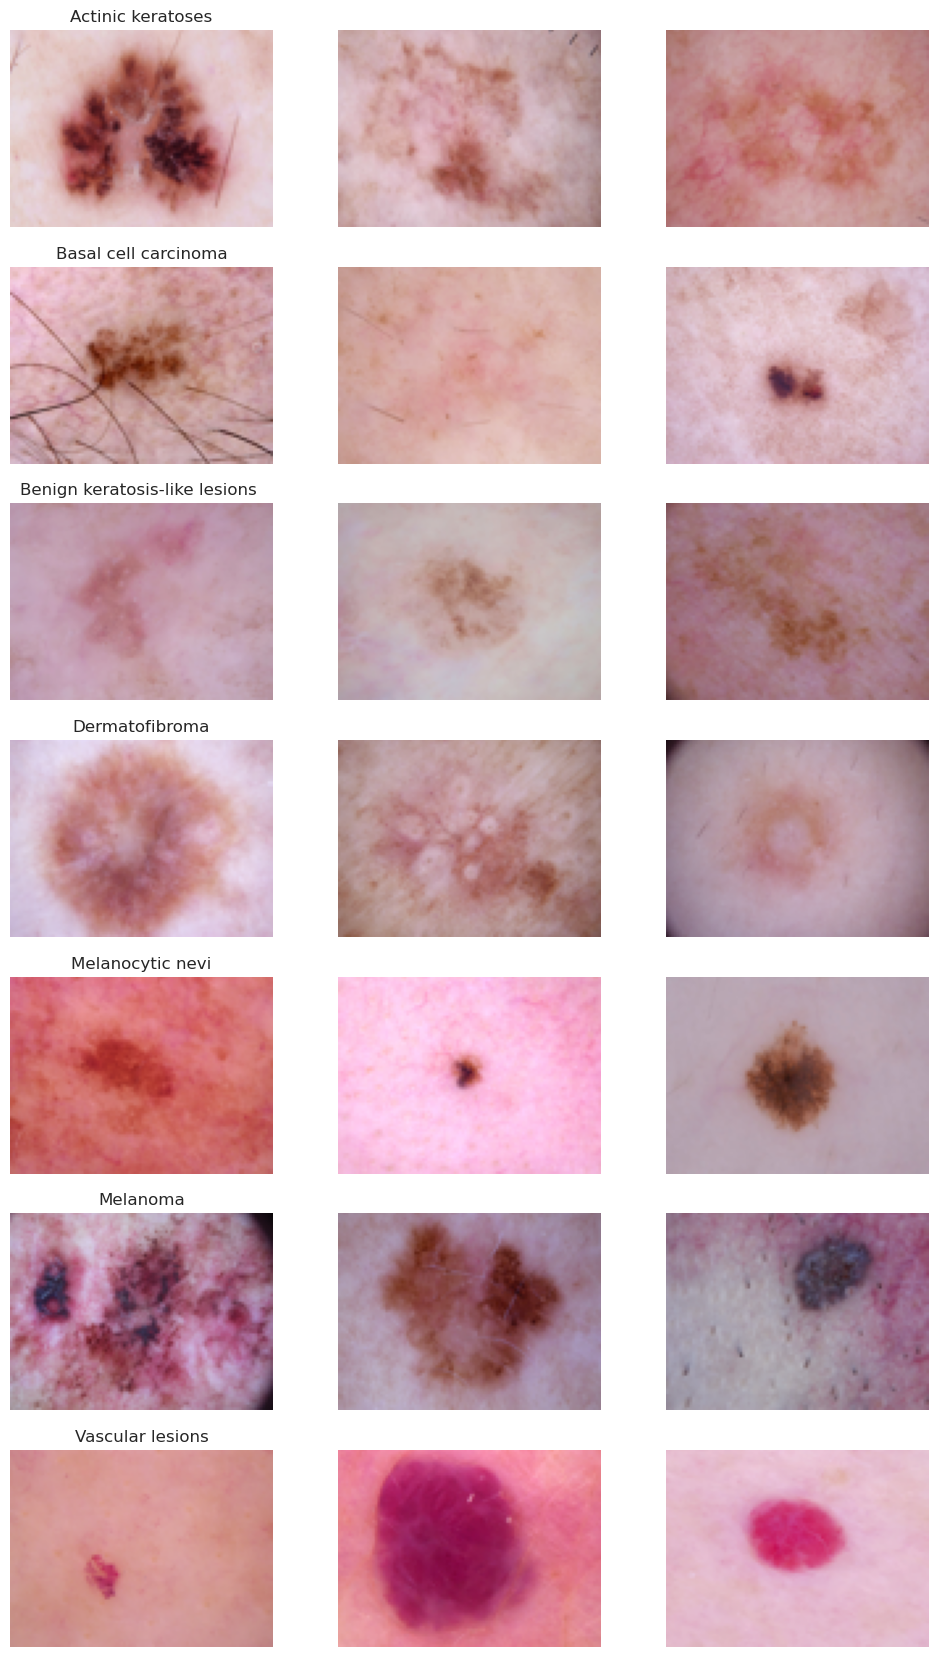

In [26]:
print(df['path'].isnull().sum(), "images non trouvées dans le dossier")
img = df.sample(n=500,replace=False, random_state=1)
img['image'] = img['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))
#Image Sampling
n_samples = 3

fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))

for n_axs, (type_name, type_rows) in zip(m_axs,img.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [27]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./data/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./data/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./data/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./data/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./data/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [28]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [29]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./data/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./data/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./data/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./data/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./data/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."


In [30]:
df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'path', 'cell_type', 'cell_type_idx', 'image'],
      dtype='object')

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input  # pour ResNet50
#from tensorflow.keras.applications.xception import preprocess_input  # pour Xception


In [32]:
train_data

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
1304,HAM_0000152,ISIC_0032244,mel,histo,75.0,female,face,./data/HAM10000_images_part_2/ISIC_0032244.jpg,Melanoma,5
9785,HAM_0001894,ISIC_0024517,akiec,histo,65.0,male,back,./data/HAM10000_images_part_1/ISIC_0024517.jpg,Actinic keratoses,0
1112,HAM_0001785,ISIC_0032941,df,histo,50.0,male,upper extremity,./data/HAM10000_images_part_2/ISIC_0032941.jpg,Dermatofibroma,3
1920,HAM_0001570,ISIC_0032872,mel,histo,55.0,male,back,./data/HAM10000_images_part_2/ISIC_0032872.jpg,Melanoma,5
9530,HAM_0004349,ISIC_0033896,nv,consensus,40.0,female,unknown,./data/HAM10000_images_part_2/ISIC_0033896.jpg,Melanocytic nevi,4
...,...,...,...,...,...,...,...,...,...,...
754,HAM_0007359,ISIC_0027354,bkl,histo,55.0,female,chest,./data/HAM10000_images_part_1/ISIC_0027354.jpg,Benign keratosis-like lesions,2
7334,HAM_0002574,ISIC_0033157,nv,histo,55.0,male,chest,./data/HAM10000_images_part_2/ISIC_0033157.jpg,Melanocytic nevi,4
1369,HAM_0001600,ISIC_0024675,mel,histo,65.0,female,lower extremity,./data/HAM10000_images_part_1/ISIC_0024675.jpg,Melanoma,5
9171,HAM_0003263,ISIC_0028226,nv,histo,25.0,male,lower extremity,./data/HAM10000_images_part_1/ISIC_0028226.jpg,Melanocytic nevi,4


In [33]:
def preprocess_image_data_with_pretrained(train_df, test_df, val_df, preprocess_func):
    """
    Prétraitement des images déjà chargées (présentes dans la colonne 'image').

    Args:
        train_df, test_df, val_df : DataFrames contenant une colonne 'image'
        preprocess_func : fonction Keras (ex : preprocess_input)

    Returns:
        x_train, x_test, x_val : tableaux numpy prétraités
    """
    # Stack les images (shape attendue : (N, H, W, 3))
    x_train = np.stack(train_df["image"].values)
    x_test = np.stack(test_df["image"].values)
    x_val = np.stack(val_df["image"].values)

    # Appliquer le prétraitement
    if preprocess_func:
        x_train = preprocess_func(x_train.astype(np.float32))
        x_test = preprocess_func(x_test.astype(np.float32))
        x_val = preprocess_func(x_val.astype(np.float32))

    return x_train, x_test, x_val


In [36]:
train_data["image"] = train_data["path"].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))

test_data["image"] = test_data["path"].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))

val_data["image"] = val_data["path"].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))


In [62]:
pre_x_train_img, pre_x_test_img, pre_x_val = preprocess_image_data_with_pretrained(train_data, test_data, val_data, 
                                                preprocess_input)

In [ ]:
train_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
1304,HAM_0000152,ISIC_0032244,mel,histo,75.0,female,face,./data/HAM10000_images_part_2/ISIC_0032244.jpg,Melanoma,5,"[[[29, 11, 16], [26, 11, 15], [25, 10, 15], [2..."
9785,HAM_0001894,ISIC_0024517,akiec,histo,65.0,male,back,./data/HAM10000_images_part_1/ISIC_0024517.jpg,Actinic keratoses,0,"[[[209, 144, 143], [210, 145, 145], [212, 142,..."
1112,HAM_0001785,ISIC_0032941,df,histo,50.0,male,upper extremity,./data/HAM10000_images_part_2/ISIC_0032941.jpg,Dermatofibroma,3,"[[[154, 144, 164], [154, 147, 164], [155, 144,..."
1920,HAM_0001570,ISIC_0032872,mel,histo,55.0,male,back,./data/HAM10000_images_part_2/ISIC_0032872.jpg,Melanoma,5,"[[[219, 204, 216], [222, 207, 221], [223, 209,..."
9530,HAM_0004349,ISIC_0033896,nv,consensus,40.0,female,unknown,./data/HAM10000_images_part_2/ISIC_0033896.jpg,Melanocytic nevi,4,"[[[154, 128, 150], [161, 134, 153], [164, 136,..."


In [96]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, Xception



class MultimodalCNNFramework:
    """
    Framework CNN multimodal combinant images et métadonnées 
    pour la prediction  du cancer et la sélection de l'équité avec sélection du meilleur modèle.
    """
    
    def __init__(self, input_shape=(224, 224, 3), num_classes=7, 
                 batch_size=32, epochs=100, learning_rate=0.001,
                 metadata_cols=None):
        """
        Initialise le framework CNN multimodal.
        
        Args:
            input_shape: Forme des images (hauteur, largeur, canaux)
            num_classes: Nombre de classes à prédire
            batch_size: Taille des batches
            epochs: Nombre d'époques d'entraînement
            learning_rate: Taux d'apprentissage initial
            metadata_cols: Liste des colonnes de métadonnées à utiliser
        """
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.metadata_cols = metadata_cols or []
        
        self.architectures = {}
        
        # initialisation des gpt si disponible
        self._setup_gpu()
        
    def _setup_gpu(self):
        """
        Configure l'utilisation du GPU si disponible.
        """
        devices_gpu = tf.config.experimental.list_physical_devices('GPU')
        
        if devices_gpu:
            try:
                for device in devices_gpu:
                    tf.config.experimental.set_memory_growth(device, True)
                print(f" GPU configuré: {len(devices_gpu)} GPU(s) disponible(s)")
            except RuntimeError as e:
                print(f"  Erreur configuration GPU: {e}")
   
   
    def prepare_features(X_train, X_test, X_val, target_col: str, transform_columns: list, save_dir: str = "encoders", fold_number: int = 0):

        os.makedirs(f'{save_dir}/fold_{fold_number}', exist_ok=True)

        # Encodage de la cible
        label_encoder = LabelEncoder()
        y_train = label_encoder.fit_transform(X_train[target_col])
        y_val = label_encoder.transform(X_val[target_col])
        print("y_train", y_train.shape)
        print("y_val", y_val.shape)   
        print('y_test', y_test.shape)
        
        
        y_test = label_encoder.transform(X_test[target_col])

        # Gestion des valeurs manquantes
        X_train = handle_missing_values(X_train)
        X_val = handle_missing_values(X_val)
        X_test = handle_missing_values(X_test)

        # One-hot encoding
        onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        col_train = onehot_encoder.fit_transform(X_train[transform_columns])
        col_val = onehot_encoder.transform(X_val[transform_columns])
        col_test = onehot_encoder.transform(X_test[transform_columns])

        # Standardisation de l'âge
        scaler_age = StandardScaler()
        age_train = scaler_age.fit_transform(X_train[['age']])
        age_val = scaler_age.transform(X_val[['age']])
        age_test = scaler_age.transform(X_test[['age']])

        print("Shape col_train:", col_train.shape)
        print("Shape age_train:", age_train.shape)

        # Combinaison des features
        X_train_tab = np.concatenate([col_train, age_train], axis=1)
        X_val_tab = np.concatenate([col_val, age_val], axis=1)
        X_test_tab = np.concatenate([col_test, age_test], axis=1)

        # Sauvegarde
        joblib.dump(label_encoder, os.path.join(f'{save_dir}/fold_{fold_number}/', f"{fold_number}_label_encoder.pkl"))
        joblib.dump(onehot_encoder, os.path.join(f'{save_dir}/fold_{fold_number}/', f"{fold_number}_onehot_encoder.pkl"))
        joblib.dump(scaler_age, os.path.join(f'{save_dir}/fold_{fold_number}/', f"{fold_number}_scaler_age.pkl"))
    
        X_train.to_csv(os.path.join(f'{save_dir}/fold_{fold_number}/', f"X_train.csv"), index=False)
        X_val.to_csv(os.path.join(f'{save_dir}/fold_{fold_number}/', f"X_val.csv"), index=False)
        X_test.to_csv(os.path.join(f'{save_dir}/fold_{fold_number}/', f"X_test.csv"), index=False),

        # Retour
        X_dict = {"train": X_train_tab, "val": X_val_tab, "test": X_test_tab}
        y_dict = {"train": y_train, "val": y_val, "test": y_test}
        transformers = {
            "label_encoder": label_encoder,
            "onehot_encoder": onehot_encoder,
        "scaler_age": scaler_age
        }

        return X_dict, y_dict, transformers

         
        
    def create_multimodal_resnet(self, metadata_dim, name="MultimodalResNet"):
        """Crée un modèle ResNet multimodal."""
        # Branche image
        base_model = ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=self.input_shape
        )
        
        # Fine-tuning
        base_model.trainable = True
        for layer in base_model.layers[:-20]:
            layer.trainable = False
        
        image_input = layers.Input(shape=self.input_shape, name='image_input')
        x = base_model(image_input)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.5)(x)
        image_features = layers.Dense(512, activation='relu', name='image_features')(x)
        
        # Branche métadonnées
        if metadata_dim > 0:
            metadata_input = layers.Input(shape=(metadata_dim,), name='metadata_input')
            meta_x = layers.Dense(128, activation='relu')(metadata_input)
            meta_x = layers.BatchNormalization()(meta_x)
            meta_x = layers.Dropout(0.3)(meta_x)
            meta_x = layers.Dense(64, activation='relu')(meta_x)
            meta_features = layers.BatchNormalization()(meta_x)
            
            # Fusion des branches
            combined = layers.concatenate([image_features, meta_features])
            combined = layers.Dense(256, activation='relu')(combined)
            combined = layers.BatchNormalization()(combined)
            combined = layers.Dropout(0.4)(combined)
            
            outputs = layers.Dense(self.num_classes, activation='softmax')(combined)
            model = models.Model(inputs=[image_input, metadata_input], outputs=outputs)
        else:
            # Modèle image uniquement
            x = layers.Dense(256, activation='relu')(image_features)
            x = layers.BatchNormalization()(x)
            x = layers.Dropout(0.3)(x)
            outputs = layers.Dense(self.num_classes, activation='softmax')(x)
            model = models.Model(inputs=image_input, outputs=outputs)
        
        self.architectures[name] = model
        print(f"model ok {name} créé - Paramètres: {model.count_params():,}")
        return model
    
    def compile_models(self):
        """Compile tous les modèles."""
        optimizer = optimizers.Adam(learning_rate=self.learning_rate)
        
        for name, model in self.architectures.items():
            model.compile(
                optimizer=Adam(learning_rate=self.learning_rate),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
            )

        
        print("----------------  Tous les modèles compilés--------------------")
        

    def create_callbacks(self, model_name, fold, save_dir="models"):
        """Crée les callbacks pour l'entraînement."""
        os.makedirs(save_dir, exist_ok=True)
        
        callbacks_list = [
            callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=10,
                min_lr=1e-7,
                verbose=1
            ),
            
            callbacks.EarlyStopping(
                monitor='val_loss',
                patience=20,
                restore_best_weights=True,
                verbose=1
            ),
            
            callbacks.ModelCheckpoint(
                filepath=f"{save_dir}/{model_name}_fold_{fold}_best.keras",
                monitor='val_accuracy',
                save_best_only=True,
                save_weights_only=False,
                verbose=1
            ),
            
            callbacks.CSVLogger(
                filename=f"{save_dir}/{model_name}_fold_{fold}_training.csv"
            )
        ]
        
        return callbacks_list
    
    def train_model(self, model_name, train_data, val_data, fold):
        """Entraîne un modèle multimodal."""
        if model_name not in self.architectures:
            raise ValueError(f"Modèle {model_name} non trouvé")
        
        model = self.architectures[model_name]
        callbacks_list = self.create_callbacks(model_name, fold)
        
        print(f"\n Entraînement {model_name} - Fold {fold}")
        print("Val generator ",val_data)
        print(f"   Train batches: {len(train_data)}")
        print(f"   Val batches: {len(val_data)}")
        
        start_time = time.time()
        
        # Entraînement
        history = model.fit(
            train_data,
            epochs=self.epochs,
            validation_data=val_data,
            callbacks=callbacks_list,
            verbose=1
        )
        
        training_time = time.time() - start_time
        
        # Stockage
        history_key = f"{model_name}_fold_{fold}"
        self.training_history[history_key] = {
            'history': history.history,
            'training_time': training_time,
            'epochs_trained': len(history.history['loss'])
        }
        
        print(f" Entraînement terminé en {training_time:.2f}s")
        return history

In [88]:
from tensorflow.keras import layers, models, optimizers, callbacks
import time

cnn = MultimodalCNNFramework(input_shape=(75, 100, 3), num_classes=7, batch_size=32, epochs=2, learning_rate=0.001)

cnn.create_multimodal_resnet(metadata_dim=X_dict["train"].shape[1], name="MultimodalResNet")
cnn.compile_models()


model ok MultimodalResNet créé - Paramètres: 24,798,791
----------------  Tous les modèles compilés--------------------


In [ ]:
X_dict["train"]

(7210, 18)

In [67]:
pre_x_train_img.shape

(7210, 75, 100, 3)

In [69]:
pre_x_val.shape

(802, 75, 100, 3)

In [72]:
X_dict["train"].shape

(7210, 18)

In [ ]:
y_dict

{'train': array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  1.36328165],
        [ 0.        ,  1.        ,  0.        , ...,  0.        ,
          0.        ,  0.77561809],
        [ 0.        ,  1.        ,  0.        , ...,  0.        ,
          1.        , -0.10587725],
        ...,
        [ 1.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.77561809],
        [ 0.        ,  1.        ,  0.        , ...,  0.        ,
          0.        , -1.57503615],
        [ 0.        ,  1.        ,  0.        , ...,  0.        ,
          0.        , -0.10587725]]),
 'val': array([[ 0.        ,  1.        ,  1.        , ...,  0.        ,
          0.        , -1.57503615],
        [ 1.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.98737259],
        [ 1.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.39970903],
        ...,
        [ 0.        ,  1.        ,  0.

In [76]:
y_dict["train"]

array([4, 0, 3, ..., 4, 5, 5])

In [89]:
def make_multimodal_dataset(images, metadata, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices(((images, metadata), labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images))
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [90]:
train_data = make_multimodal_dataset(pre_x_train_img, X_dict["train"], y_dict["train"], batch_size=32)
val_data   = make_multimodal_dataset(pre_x_val, X_dict['val'],y_dict['val'] , batch_size=32, shuffle=False)


2025-07-05 18:11:00.089999: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 648900000 exceeds 10% of free system memory.


In [94]:
y_dict["test"]

array([2, 2, 2, ..., 0, 0, 0])

In [92]:
# 2. Entraîne le modèle
cnn.train_model(
    model_name="MultimodalResNet",
    train_data=train_data,
    val_data=val_data,
    fold=0
)



 Entraînement MultimodalResNet - Fold 0
Val generator  <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 75, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float64, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
   Train batches: 226
   Val batches: 26
Epoch 1/2


2025-07-05 18:11:05.338555: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 648900000 exceeds 10% of free system memory.


InvalidArgumentError: Graph execution error:

Detected at node LogicalAnd_1 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/herman/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/herman/anaconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/herman/anaconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/home/herman/anaconda3/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/herman/anaconda3/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/home/herman/anaconda3/lib/python3.12/asyncio/base_events.py", line 1986, in _run_once

  File "/home/herman/anaconda3/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/herman/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/home/herman/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/home/herman/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/home/herman/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/home/herman/anaconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/home/herman/anaconda3/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/herman/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/herman/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/herman/anaconda3/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/herman/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/herman/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/herman/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_73200/933968548.py", line 2, in <module>

  File "/tmp/ipykernel_73200/3942378925.py", line 226, in train_model

  File "/home/herman/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/herman/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/herman/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/herman/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/home/herman/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/home/herman/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 84, in train_step

  File "/home/herman/anaconda3/lib/python3.12/site-packages/keras/src/trainers/trainer.py", line 490, in compute_metrics

  File "/home/herman/anaconda3/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 334, in update_state

  File "/home/herman/anaconda3/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 21, in update_state

  File "/home/herman/anaconda3/lib/python3.12/site-packages/keras/src/metrics/confusion_metrics.py", line 378, in update_state

  File "/home/herman/anaconda3/lib/python3.12/site-packages/keras/src/metrics/metrics_utils.py", line 592, in update_confusion_matrix_variables

  File "/home/herman/anaconda3/lib/python3.12/site-packages/keras/src/metrics/metrics_utils.py", line 565, in weighted_assign_add

  File "/home/herman/anaconda3/lib/python3.12/site-packages/keras/src/ops/numpy.py", line 3686, in logical_and

  File "/home/herman/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/numpy.py", line 1629, in logical_and

Incompatible shapes: [1,224] vs. [1,32]
	 [[{{node LogicalAnd_1}}]] [Op:__inference_multi_step_on_iterator_69835]